In [1]:
# %matplotlib widget

In [2]:
import os
import glob
from natsort import natsorted
from tqdm import tqdm
import itertools

import pandas as pd
import numpy as np

from nilearn import image
import nibabel as nib

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

from scipy.stats import pearsonr, zscore, ttest_1samp
from statsmodels.stats.multitest import fdrcorrection

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
bids_dir = '/Users/emcmaho7/Desktop/SI_fMRI'
derivatives_dir = f'{bids_dir}/derivatives'
fmriprep_dir = f'{derivatives_dir}/fmriprep'
nilearn_dir = f'{derivatives_dir}/nilearn'
reliability_dir = f'{derivatives_dir}/reliability'
mask_dir = f'{derivatives_dir}/ROI_masks'
em_dir = f'{derivatives_dir}/encoding_models'

In [4]:
rois = ['EVC', 'MT', 'EBA', 'PPA', 'TOS', 'RSC', 'LOC',  'FFA', 'OFA', 'faceSTS', 'biomotion', 'SIpSTS', 'TPJ', 'DMPFC']
roi_names = ['EVC', 'MT', 'EBA', 'PPA', 'OPA', 'RSC', 'LOC',  'FFA', 'OFA', 'faceSTS', 'biomotion', 'SIpSTS', 'TPJ', 'DMPFC']

In [5]:
from nilearn import surface, image, datasets, plotting
fsaverage = datasets.fetch_surf_fsaverage()

/Applications/anaconda3/envs/nilearn/lib/python3.6/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


# Loading

## Zmaps

In [28]:
fname = f'{nilearn_dir}/sub-all_task-SIdyads_desc-train_stat-z_statmap.npy'
z_maps = np.load(fname)
n_subjs = z_maps.shape[0]
tot_voxels = z_maps.shape[1]

## Features

### AlexNet

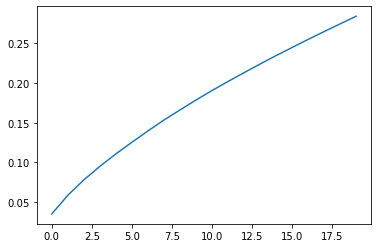

In [7]:
layer = 2
alexnet = zscore(np.load(f'alexnet_conv{layer}_avgframe.npy'), axis=-1)

pca = PCA(svd_solver='full', n_components=20)
alexnet = pca.fit_transform(alexnet.T)

fig, ax = plt.subplots()
plt.plot(pca.explained_variance_ratio_.cumsum())

### Optical flow

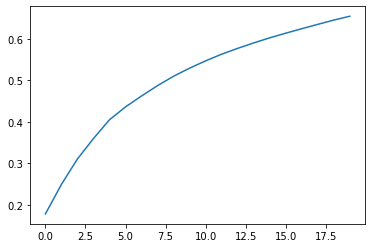

In [8]:
of = zscore(np.load(f'of_adelsonbergen.npy'), axis=0)
pca = PCA(svd_solver='full', n_components=20)
of = pca.fit_transform(of)

fig, ax = plt.subplots()
plt.plot(pca.explained_variance_ratio_.cumsum())

### Control model

In [9]:
control_model = np.concatenate((alexnet, of), axis=-1)

In [10]:
control_model.shape

(200, 40)

### Annotated Model

In [11]:
bdf = pd.read_csv('annotations/annotations.csv')
train = pd.read_csv('annotations/train.csv')
bdf = bdf.merge(train)
bdf.sort_values(by=['video_name'], inplace=True)

In [12]:
feature_categories = ['visual', 'visual', 'visual', 'visual', 'visual',
                     'social detection', 'social detection', 
                     'social evaluation', 'social evaluation', 'social evaluation', 'social evaluation', 'social evaluation']
features = bdf.columns.to_list()
features.remove('video_name')

In [13]:
model = []
for feature in features:
    arr = zscore(bdf[feature].to_numpy())
    arr = np.expand_dims(arr, axis=0)
    if type(model) == list:
        model = arr.copy()
    else:
        model = np.append(model, arr, axis=0) 
X = model.T

# Reliability

## All pairs of runs

In [14]:
def reliability(z_map):
    n_voxels = z_map.shape[0]
    rs = np.zeros(n_voxels)
    even, odd = z_map[..., 1::2].mean(axis=-1), z_map[..., ::2].mean(axis=-1)
    for ivoxel in tqdm(range(n_voxels)):
        if np.any(np.isnan(even[ivoxel, :])) or np.any(np.isnan(odd[ivoxel, :])):
            r = np.nan
        else:
            r, _ = pearsonr(even[ivoxel, :], odd[ivoxel, :])
        rs[ivoxel] += r
    return rs

In [15]:
r_file = f'{reliability_dir}/sub-all_task-SIdyads_desc-test_stat-r_statmap.npy'
if not os.path.exists(r_file):
    files = sorted(glob.glob(f'{nilearn_dir}/*/sub-*_task-SIdyads_desc-train_stat-z_statmap.npy'))
    n_voxels = 1175640
    r_maps = np.zeros((n_subjs, n_voxels))
    for ifile, file in enumerate(files):
        r_maps[ifile, :] = reliability(np.load(file))
else:
    r_maps = np.load(r_file)

In [16]:
n_subjs = 4
reliability = np.zeros((len(rois), n_subjs))
for iroi, (roi, roi_name) in enumerate(zip(rois, roi_names)):
    for sid_ in range(n_subjs): 
        sid = str(sid_+1).zfill(2)
        #activity in ROI
        mask = image.load_img(glob.glob(f'{mask_dir}/sub-{sid}/*region-{roi}*nooverlap.nii.gz')[0])
        mask = np.array(mask.dataobj, dtype='bool').flatten()
        roi_activation = z_maps[sid_, mask, :]
        roi_r = r_maps[sid_, mask]

        #Remove nan values (these are voxels that do not vary across the different videos)
        inds = ~np.any(np.isnan(roi_activation), axis=1)
        reliability[iroi, sid_] = roi_r[inds].mean()

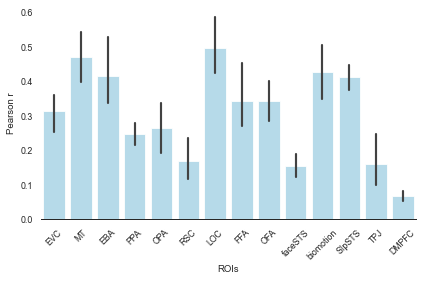

In [17]:
subjects = [f'sub-{i+1:02d}' for i in range(n_subjs)]

noise_ceiling = pd.DataFrame(reliability.T, columns=roi_names, index=subjects)
noise_ceiling.reset_index(inplace=True)
noise_ceiling.rename(columns={'index': 'Subjects'}, inplace=True)
noise_ceiling = pd.melt(noise_ceiling, id_vars='Subjects', 
         var_name='ROIs',
         value_vars=roi_names, value_name='Pearson r')

noise_ceiling['Explained variance'] = noise_ceiling['Pearson r']**2

sns.set(style='white', context='paper')
fig, ax = plt.subplots()
sns.barplot(x='ROIs', y='Pearson r',
        data=noise_ceiling, ax=ax, color='#ADDDF2')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
sns.despine(left=True)
plt.tight_layout()

In [18]:
noise_ceiling = noise_ceiling.groupby('ROIs').mean().reset_index()

# Encoding models

## Functions

### Activation

In [19]:
def get_activation(z_map, path=None):
    #activity in ROI
    if path is not None: 
        mask = nib.load(path)
        mask_arr = np.array(mask.dataobj, dtype='bool').flatten()
    else:
        mask_arr = np.ones((z_map.shape[:-1]), dtype='bool')  
    activation = z_map[mask_arr, :]
    
    #Remove nan values (these are voxels that do not vary across the different videos)
    inds = ~np.any(np.isnan(activation), axis=1)
    return activation[inds, ...].T, inds

### Regression

In [20]:
def regression(X_train_, y_train_, X_test_, features): 
    n_voxels = y_train_.shape[1]

    #Standardize X
    scaler = StandardScaler()
    X_train_ = scaler.fit_transform(X_train_)

    #Ridge CV to get the alpha parameter
    clf = RidgeCV(cv=4).fit(X_train_, y_train_)

    #Fit the Ridge model with the found best alpha
    lr = Ridge(fit_intercept=False, alpha=clf.alpha_).fit(X_train_, y_train_)

    #Scale testing 
    mean = scaler.mean_[:X_test_.shape[1]]
    var = scaler.var_[:X_test_.shape[1]]
    X_test_ = (X_test_ - mean)/var

    y_pred = np.zeros((len(features), X_test_.shape[0], n_voxels))
    for ifeature, feature in enumerate(features):
        y_pred[ifeature, :, :] = np.multiply.outer(X_test_[:, ifeature], lr.coef_[:, ifeature])
    return y_pred

### corr2d

In [21]:
def corr2d(a, b):
    a = a.T
    b = b.T
    
    a_m = a - a.mean(axis=0)
    b_m = b - b.mean(axis=0)

    r = np.zeros(b.shape[0])
    for i in range(b.shape[0]): 
        r[i] = (a_m[i, :] @ b_m[i, :]) / (np.sqrt((a_m[i, :] @ a_m[i, :]) * (b_m[i, :] @ b_m[i, :]))) 
    return r

### corr1d

In [22]:
def corr1d(a, b):
    a_m = a - a.mean()
    b_m = b - b.mean()
    
    return (a_m @ b_m) / (np.sqrt((a_m @ a_m) * (b_m @ b_m))) 

### Perm

In [23]:
def permutation_test(y_pred, y_true, test_inds, n_perm=int(5e3), H0='greater'): 
    r_true = corr1d(y_pred, y_true)
    r_null = np.zeros(n_perm)
    for i in range(n_perm):
        inds = np.random.default_rng(i).permutation(test_inds.shape[0])
        inds = test_inds[inds, :].flatten()
        y_true_shuffle = y_true[inds]
        r_null[i] = corr1d(y_true_shuffle, y_pred)
    if H0 == 'two_tailed':
        p = np.sum(np.abs(r_null) >= np.abs(r_true)) / n_perm
    elif H0 == 'greater':
        p = 1 - (np.sum(r_true >= r_null) / n_perm)
    return r_true, p, r_null

### Bootstrap

In [24]:
def bootstrap(y_pred, y_true, test_inds, n_samples=int(5e3)):
    r_var = np.zeros(n_samples)
    for i in range(n_samples):
        inds = np.random.default_rng(i).choice(np.arange(test_inds.shape[0]), size=test_inds.shape[0])
        inds = test_inds[inds, :].flatten()
        r_var[i] = corr1d(y_true[inds], y_pred[inds])
    return r_var

## Run Models

In [41]:
variable='Pearson r'
df = pd.DataFrame()

n_splits = 2
n_conditions = 200
n_condpersplit = int(n_conditions/n_splits)
n_features = len(features)
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)

#Save the rs and null distributions
rs = np.zeros((n_subjs, len(features), tot_voxels))
for sid_ in range(4): 
    sid = str(sid_+1).zfill(2)
    y, y_inds = get_activation(z_maps[sid_, ...], None)
    n_voxels = y.shape[-1]     

    #Iterate through the different splits
    y_pred = np.zeros((n_splits, n_features, n_condpersplit, n_voxels))
    y_true = np.zeros((n_splits, n_condpersplit, n_voxels))
    test_inds = np.zeros((n_splits, n_condpersplit), dtype='int')
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        #Split the training and test data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #save the current indices
        test_inds[i, ...] = test_index
        y_true[i, ...] = y_test

        #new X - combine the annotated features with the nuissance regressors
        X_train = np.append(X_train, control_model[train_index], axis=1)

        #Prediction
        y_pred[i, ...] = regression(X_train, y_train, X_test, features)
    y_pred = np.moveaxis(y_pred, 0, -3).reshape((n_features, n_conditions, -1))
    y_true = y_true.reshape((n_conditions, n_voxels))
    
    for ifeature, cat in enumerate(features):
        rs[sid_, ifeature, y_inds] = corr2d(y_true, y_pred[ifeature, ...])

## GET ROIs

In [44]:
def get_performance(path, brain_map):
    #activity in ROI
    mask = image.load_img(path)
    mask = np.array(mask.dataobj, dtype='bool').flatten()
    perf = brain_map[mask]
    return perf.mean(axis=0)

In [53]:
def plot_ROI_results(df, outname, variable):
    features = df.Features.unique()
    n_features = len(features)
    roi = df.ROIs.unique()[0]

    #Set up figures
    sns.set(style='whitegrid', context='talk', rc={'figure.figsize':(6,5)})
    fig, ax = plt.subplots()

    colors = ['#48D4E1', '#8C55FD', '#FADC00']
    cmap = sns.color_palette(colors, as_cmap=True)
    g = sns.swarmplot(x='Features', y=variable,
                    data=df, ax=ax,
                    hue='Feature category',
                    palette=cmap,
                    dodge=False)#, ci=None)

    #Plot noise ceiling
    x = np.linspace(0, n_features, num=3)
    y1 = np.ones_like(x)*noise_ceiling.loc[noise_ceiling.ROIs == roi, variable].tolist()[0]
    ax.plot(x, y1, color='gray', alpha=0.5, linewidth=3)
    
#     for ifeature, feature in enumerate(df.Features.unique()):
#         x = ifeature
#         sig = df.loc[df.Features == feature, 'group sig'].reset_index(drop=True)[0]
#         p = df.loc[df.Features == feature, 'group_pcorrected'].reset_index(drop=True)[0]
#         if sig:
#             if p >= 0.01:
#                 text = '*'
#             elif p < 0.01 and p >= 0.001:
#                 text = '**'
#             elif p < 0.001:
#                 text = '***'
#             ax.annotate(text, (x, 0.5), fontsize=20,
#                         weight='bold', ha='center', color='gray')
            
#         y1 = df[(df.Features == feature)].mean()['low sem']
#         y2 = df[(df.Features == feature)].mean()['high sem']
#         plt.plot([x, x], [y1, y2], 'black', linewidth=2)

    # #Aesthetics
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
    ax.set_xlabel('')
    ax.set_ylabel('Prediction accuracy ($\it{r}$)')
#     ax.tick_params(axis='y', labelsize=12)
    ax.set_ylim([-0.38, 0.58])
    sns.despine(left=True)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend([],[], frameon=False)
    plt.tight_layout()
    if outname is not None:
        plt.savefig(outname)
        plt.close()
    else:
        plt.title(roi)

In [45]:
df = pd.DataFrame()
for iroi, (roi, roi_name) in enumerate(zip(rois, roi_names)):
    for ifeature, (feature, category) in enumerate(zip(features, feature_categories)):
        for sid_ in range(4): 
            sid = str(sid_+1).zfill(2)
            
            r = get_performance(glob.glob(f'{mask_dir}/sub-{sid}/*region-{roi}*nii.gz')[0],
                                rs[sid_, ifeature, ...])
            
            df = df.append({'Subjects': f'sub-{sid}',
                'Features': feature,
                'Feature category': category,
                'ROIs': roi_name, 
                'Pearson r': r},
                ignore_index=True)

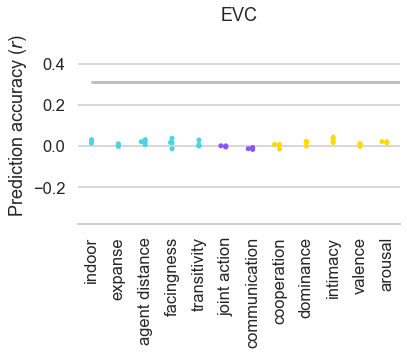

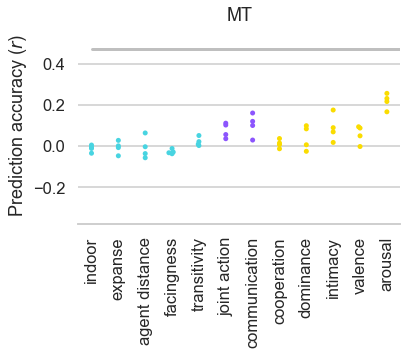

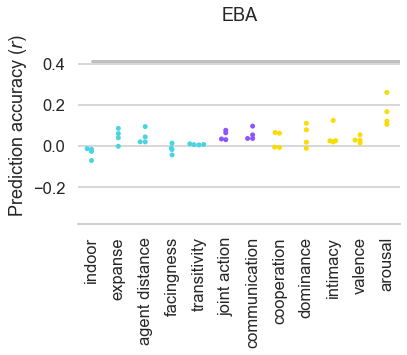

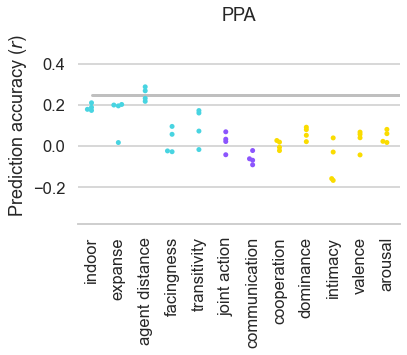

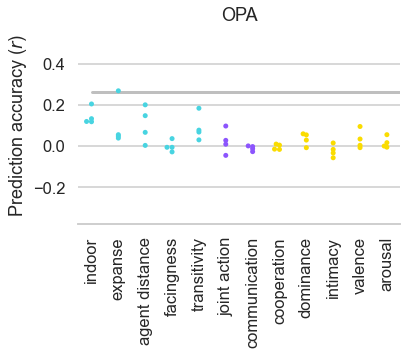

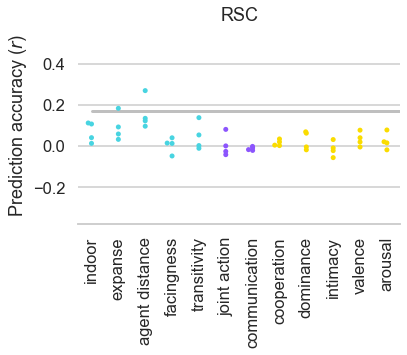

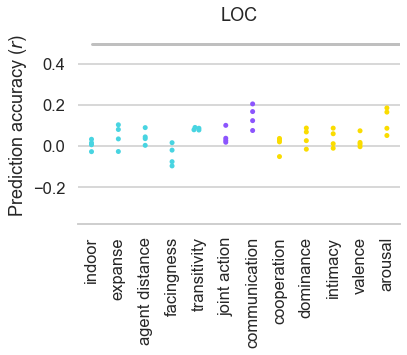

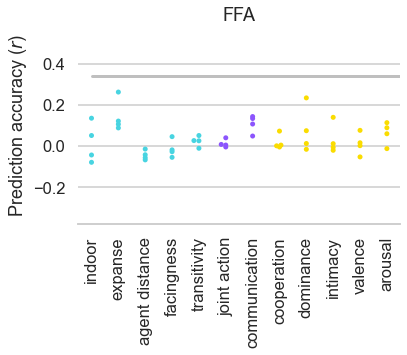

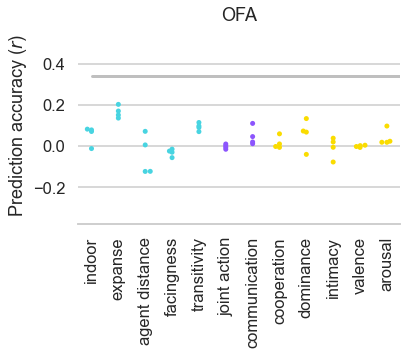

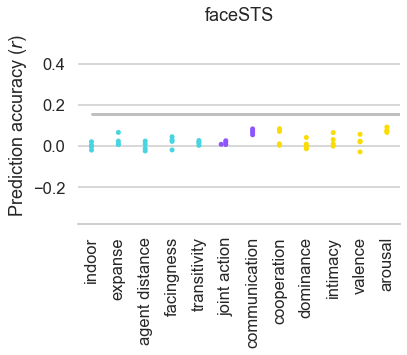

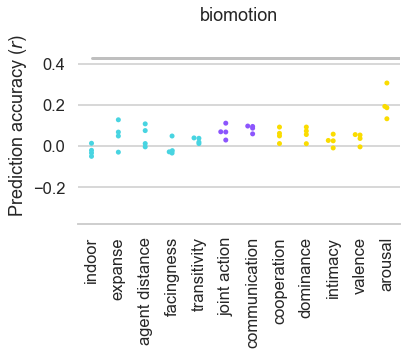

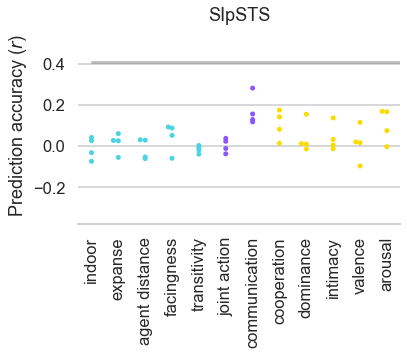

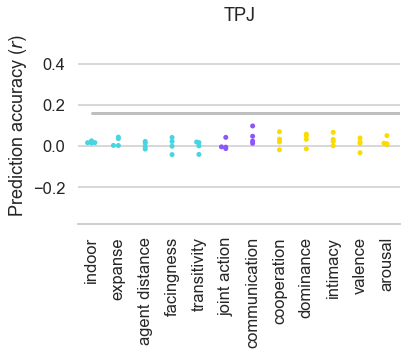

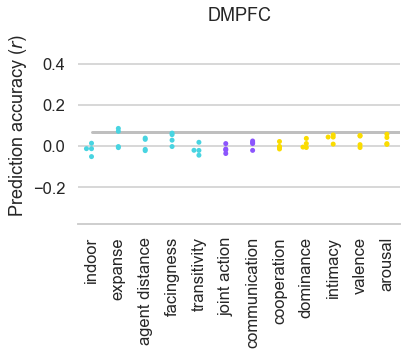

In [54]:
variable='Pearson r'
for roi in roi_names:
    plot_ROI_results(df[df.ROIs == roi], None, variable)